<a href="https://colab.research.google.com/github/saksham1965/sakkyai/blob/main/TRADING%20BOT%20USING%20AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
pip install yfinance pandas numpy scikit-learn matplotlib tensorflow


In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


/tmp/ipython-input-4212248574.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=period, interval=interval)
[*********************100%***********************]  1 of 1 completed


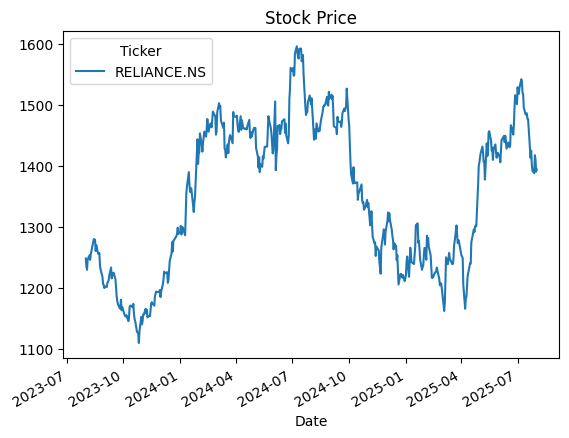

In [63]:
def get_stock_data(ticker=['RELIANCE.NS'], period='2y', interval='1d'):
    data = yf.download(ticker, period=period, interval=interval)
    # When downloading multiple tickers, yfinance returns a MultiIndex DataFrame.
    # We need to select the 'Close' price for each ticker.
    data = data['Close']
    data.dropna(inplace=True)
    return data

data = get_stock_data()
data.plot(title="Stock Price")
plt.show()

In [45]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_dataset(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_dataset(scaled_data, seq_length)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


In [46]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=10, batch_size=32)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.1529
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0195
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0142
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0118
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0102
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0099
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0091
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0094
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0089
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0084


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


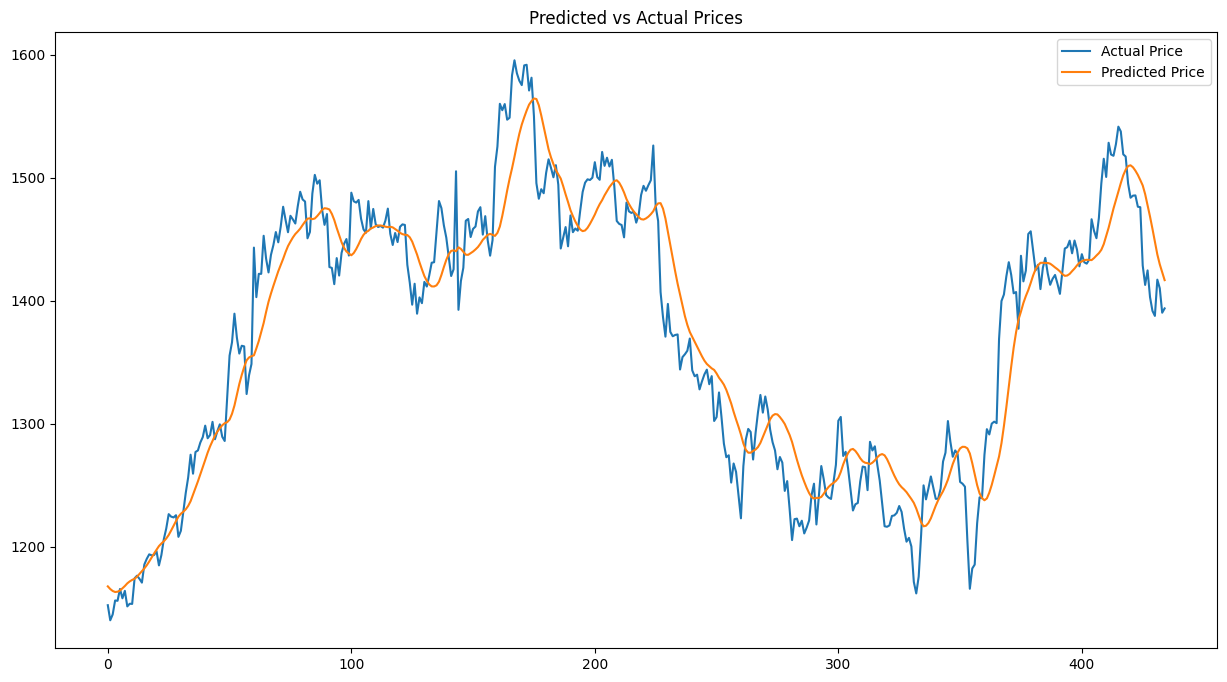

In [57]:
predicted_prices = model.predict(X)
predicted_prices = scaler.inverse_transform(predicted_prices)
real_prices = scaler.inverse_transform(y.reshape(-5, 1))

plt.figure(figsize=(15, 8))
plt.plot(real_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.legend()
plt.title("Predicted vs Actual Prices")
plt.show()


In [49]:
initial_balance = 10000
balance = initial_balance
stock_holdings = 0
trade_log = []

for i in range(1, len(predicted_prices)):
    real_price = real_prices[i][0]
    prev_real_price = real_prices[i-1][0]
    predicted_price = predicted_prices[i][0]

    # Buy signal
    if predicted_price > real_price and balance >= real_price:
        num_shares = balance // real_price
        balance -= num_shares * real_price
        stock_holdings += num_shares
        trade_log.append((i, 'BUY', num_shares, real_price))

    # Sell signal
    elif predicted_price < real_price and stock_holdings > 0:
        balance += stock_holdings * real_price
        trade_log.append((i, 'SELL', stock_holdings, real_price))
        stock_holdings = 0

# Final portfolio value
final_value = balance + stock_holdings * real_prices[-1][0]
profit = final_value - initial_balance

print(f"Initial balance: Rs{initial_balance:.2f}")
print(f"Final balance:   Rs{final_value:.2f}")
print(f"Total profit:    Rs{profit:.2f}")
print(f"Total trades:    {len(trade_log)}")


Initial balance: Rs10000.00
Final balance:   Rs12238.48
Total profit:    Rs2238.48
Total trades:    71


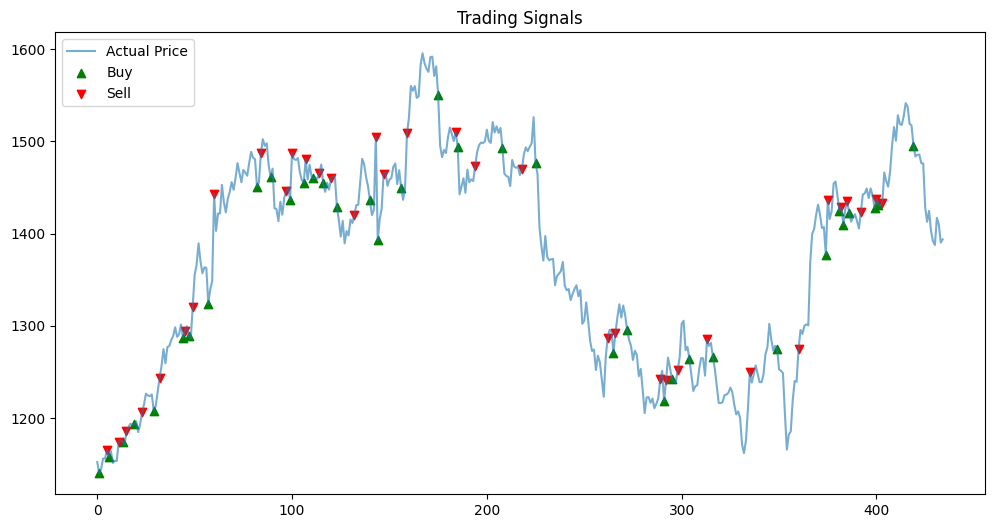

In [50]:
buy_signals = [i for i, action, _, _ in trade_log if action == 'BUY']
sell_signals = [i for i, action, _, _ in trade_log if action == 'SELL']

plt.figure(figsize=(12, 6))
plt.plot(real_prices, label='Actual Price', alpha=0.6)
plt.scatter(buy_signals, [real_prices[i][0] for i in buy_signals], label='Buy', marker='^', color='green')
plt.scatter(sell_signals, [real_prices[i][0] for i in sell_signals], label='Sell', marker='v', color='red')
plt.legend()
plt.title("Trading Signals")
plt.show()
